In [1]:
import glob
import numpy as np
import datetime
import xarray as xr

from pyxlma.lmalib.io import read as lma_read
from pyxlma.plot.xlma import XlmaPlot

from pyxlma.lmalib.flash.cluster import cluster_flashes

%matplotlib inline

In [2]:
files_grabbed = sorted(glob.glob('../test/vanna/kinda/L*'))
lma_data, starttime = lma_read.dataset(files_grabbed)
print(files_grabbed)


# lf = read.lmafile(files_grabbed[-1])
# Station info comes from the last file read.
# stations = lma_file.stations

# Will need to add logic to check for existing data and do something else if it is
# if len(lma_data) > 0:
#     lma_data.sort_values('Datetime', inplace=True)

dttuple = [starttime, starttime+datetime.timedelta(minutes=10)]
# dttuple = lma_data.Datetime.min(), lma_data.Datetime.max()
tstring = 'Oklahoma LMA {}-{}'.format(dttuple[0].strftime('%H%M'),
                                      dttuple[1].strftime('%H%M UTC %d %B %Y '))
print(tstring)

['../test/vanna/kinda/LYLOUT_200402_230000_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230100_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230200_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230300_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230400_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230500_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230600_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230700_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230800_0060.dat.gz', '../test/vanna/kinda/LYLOUT_200402_230900_0060.dat.gz']
Oklahoma LMA 2300-2310 UTC 02 April 2020 


In [3]:
ds = cluster_flashes(lma_data)

In [4]:
def flash_stat_iter(fl_gb):    
    for fl_id, ds in fl_gb:
        init_lon = ds['event_longitude'][0]
        init_lat = ds['event_latitude'][0]
        init_alt = ds['event_altitude'][0]
        ctr_lon = ds['event_longitude'].mean()
        ctr_lat = ds['event_latitude'].mean()
        ctr_alt = ds['event_altitude'].mean()
        n_events = ds.dims['number_of_events']
#         total_power = ds.event_power.sum()
#         mean_stations = ds.event_stations.mean()
#         mean_chi2 = ds.event_chi2.mean()
        
        yield(fl_id, n_events, ctr_lon, ctr_lat, ctr_alt,
              init_lon, init_lat, init_alt,
#               total_power, mean_stations, mean_chi2
             )


def flash_stats(ds):
    fl_gb = ds.groupby('event_parent_flash_id')
    n_flashes = len(fl_gb.groups)
    fl_stat_dtype = [('fl_id', 'u8'),
                     ('flash_event_count', 'u8'),
                     ('flash_center_longitude', 'f8'),
                     ('flash_center_latitude', 'f8'),
                     ('flash_center_altitude', 'f8'),
                     ('flash_init_longitude', 'f8'),
                     ('flash_init_latitude', 'f8'),
                     ('flash_init_altitude', 'f8'),
#                      ('event_total_power','f8'),
#                      ('event_mean_stations', 'f4'),
#                      ('event_mean_chi2', 'f4'),
                    ]
    ev_iter = flash_stat_iter(fl_gb)
    agg = np.fromiter(ev_iter, dtype=fl_stat_dtype, count=n_flashes)
    
    ds=ds.set_index(number_of_flashes='flash_id')
    to_assign = ('flash_event_count',
                 'flash_center_longitude',
                 'flash_center_latitude',
                 'flash_center_altitude',
                 'flash_init_longitude',
                 'flash_init_latitude',
                 'flash_init_altitude'
                )
    for var in to_assign:
        ds[var][agg['fl_id']] = agg[var]
    ds.reset_index('number_of_flashes')
    ds['flash_id']=ds['number_of_flashes']
    return ds

ds = flash_stats(ds)

In [5]:
ds

<xarray.Dataset>
Dimensions:                              (number_of_events: 35436, number_of_flashes: 2171, number_of_stations: 18)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 0 1 ... 2170
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude              float64 35.28
    network_center_longitude             float64 -97.92
    network_center_altitude              float64 417.9
    station_latitude                     (number_of_stations) float32 35.00434 ... 34.711586
    station_longitude                    (number_of_stations) float32 -97.907295 ... -99.08027
    station_altitude                     (number_of_stations) float32 346.0 ... 415.89996
    station_event_fraction               (number_of_stations) float32 66.71001 ... 96.81
    station_power_ratio                  (number_of_stations) float32 1.9909999 ... 0.842
    event_latitude                       (number_of_events) float32 35.37887 ... 35.386784
    event_longitude                      (number_of_events) float32 -99.74041 ... -99.712746
    event_altitude                       (number_of_events) float32 11685.61 ... 2567.21
    event_time                           (number_of_events) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.305506673
    event_power                          (number_of_events) float32 12.9 ... 3.4
    event_mask                           (number_of_events) uint32 1015 ... 245
    event_stations                       (number_of_events) uint8 9 6 6 ... 8 6
    event_chi2                           (number_of_events) float32 0.05 ... 0.29
    event_contributing_stations          (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                             (number_of_events) uint64 0 1 ... 35435
    station_code                         (number_of_stations) object b'C' ... b'Z'
    flash_distance_separation_threshold  float64 3e+03
    flash_time_separation_threshold      float64 0.15
    flash_duration_threshold             float64 nan
    flash_time_merge_threshold           float64 nan
    flash_time_start                     (number_of_flashes) float64 nan ... nan
    flash_time_end                       (number_of_flashes) float64 nan ... nan
    flash_duration                       (number_of_flashes) float64 nan ... nan
    flash_init_latitude                  (number_of_flashes) float32 35.37887 ... 35.411808
    flash_init_longitude                 (number_of_flashes) float32 -99.74041 ... -99.762566
    flash_init_altitude                  (number_of_flashes) float32 11685.61 ... 7825.12
    flash_area                           (number_of_flashes) float32 nan ... nan
    flash_volume                         (number_of_flashes) float32 nan ... nan
    flash_center_latitude                (number_of_flashes) float32 35.376465 ... 35.40959
    flash_center_longitude               (number_of_flashes) float32 -99.73503 ... -99.75267
    flash_center_altitude                (number_of_flashes) float32 11450.305 ... 8560.734
    flash_event_count                    (number_of_flashes) uint32 2 392 ... 2
    event_parent_flash_id                (number_of_events) uint64 0 0 ... 2166
    flash_id                             (number_of_flashes) uint64 0 1 ... 2170
Attributes:
    production_date:          2020-07-19 03:29:16 +00:00
    event_algorithm_name:      /data1/rtlma/bin/lma_analysis_v10.14.5R/lma_an...
    comment:                  
    flash_algorithm_version:  0.1
    production_site:          Default
    event_algorithm_version:   10.14.5R
    history:                  LMA source file created  Thu Apr  2 18:01:21 20...
    institution:              unknown
    title:                    Lightning Mapping Array Dataset, L1b events and...
    references:               
    source:                   VHF Lightning Mapping Array
    flash_algorithm_name:     pyxlma DBSCAN

In [6]:
ds0 = ds.copy()

In [7]:
ds0

<xarray.Dataset>
Dimensions:                              (number_of_events: 35436, number_of_flashes: 2171, number_of_stations: 18)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 0 1 ... 2170
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude              float64 35.28
    network_center_longitude             float64 -97.92
    network_center_altitude              float64 417.9
    station_latitude                     (number_of_stations) float32 35.00434 ... 34.711586
    station_longitude                    (number_of_stations) float32 -97.907295 ... -99.08027
    station_altitude                     (number_of_stations) float32 346.0 ... 415.89996
    station_event_fraction               (number_of_stations) float32 66.71001 ... 96.81
    station_power_ratio                  (number_of_stations) float32 1.9909999 ... 0.842
    event_latitude                       (number_of_events) float32 35.37887 ... 35.386784
    event_longitude                      (number_of_events) float32 -99.74041 ... -99.712746
    event_altitude                       (number_of_events) float32 11685.61 ... 2567.21
    event_time                           (number_of_events) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.305506673
    event_power                          (number_of_events) float32 12.9 ... 3.4
    event_mask                           (number_of_events) uint32 1015 ... 245
    event_stations                       (number_of_events) uint8 9 6 6 ... 8 6
    event_chi2                           (number_of_events) float32 0.05 ... 0.29
    event_contributing_stations          (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                             (number_of_events) uint64 0 1 ... 35435
    station_code                         (number_of_stations) object b'C' ... b'Z'
    flash_distance_separation_threshold  float64 3e+03
    flash_time_separation_threshold      float64 0.15
    flash_duration_threshold             float64 nan
    flash_time_merge_threshold           float64 nan
    flash_time_start                     (number_of_flashes) float64 nan ... nan
    flash_time_end                       (number_of_flashes) float64 nan ... nan
    flash_duration                       (number_of_flashes) float64 nan ... nan
    flash_init_latitude                  (number_of_flashes) float32 35.37887 ... 35.411808
    flash_init_longitude                 (number_of_flashes) float32 -99.74041 ... -99.762566
    flash_init_altitude                  (number_of_flashes) float32 11685.61 ... 7825.12
    flash_area                           (number_of_flashes) float32 nan ... nan
    flash_volume                         (number_of_flashes) float32 nan ... nan
    flash_center_latitude                (number_of_flashes) float32 35.376465 ... 35.40959
    flash_center_longitude               (number_of_flashes) float32 -99.73503 ... -99.75267
    flash_center_altitude                (number_of_flashes) float32 11450.305 ... 8560.734
    flash_event_count                    (number_of_flashes) uint32 2 392 ... 2
    event_parent_flash_id                (number_of_events) uint64 0 0 ... 2166
    flash_id                             (number_of_flashes) uint64 0 1 ... 2170
Attributes:
    production_date:          2020-07-19 03:29:16 +00:00
    event_algorithm_name:      /data1/rtlma/bin/lma_analysis_v10.14.5R/lma_an...
    comment:                  
    flash_algorithm_version:  0.1
    production_site:          Default
    event_algorithm_version:   10.14.5R
    history:                  LMA source file created  Thu Apr  2 18:01:21 20...
    institution:              unknown
    title:                    Lightning Mapping Array Dataset, L1b events and...
    references:               
    source:                   VHF Lightning Mapping Array
    flash_algorithm_name:     pyxlma DBSCAN

In [8]:
def discretize(x, x0, dx, int_type='uint64', bounds_check=True):
    """ Calculate a unique location ID given some
        discretization interval and allowed range.
        
        Values less than x0 raise an exception of bounds_check=True,
        othewise the assigned index may wrap according when integer
        casting is performed.

        Arguments:
        x: coordinates, float array
        x0: minimum x value
        dx: discretization interval

        Keyword arguments:
        int_type: numpy dtype of x_id. 64 bit unsigned int by default, since 32 bit
            is limited to a 65536 pixel square grid.

        Returns:
        x_id = unique pixel ID
        
        assert (np.array([0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3], dtype='uint64') == discretize(np.asarray([-2.0, -1.5, -1.0, -0.1, 0.0, 0.1, 0.4, 0.5, 0.6, 0.9, 1.0, 1.1]), -2.00, 1.0)).all()
    """
    if bounds_check:
        if (x<x0).any():
            raise ValueError("Some values are less than minimum")
    x_discr = ((x - x0) / dx).astype(int_type)
    return x_discr

def unique_ids(d, maxes, name='pixel_id'):
    """ Convert multidimensional integer pixel indices into a unique pixel_id.
    The maximum ID value is the product of all values in maxes.
    
    d is a list of 1D pixel ID arrays of the same length, d = [x, y, z, …]
    maxes is a list or array of the maximum value allowed along each coordinate in d.
    """
    cumprod = np.cumprod(maxes)
    # Example for 4D data
    #     d[0] + d[1]*maxes[0] + d[2]*maxes[0]*maxes[1] + d[3]*maxes[0]*maxes[1]*maxes[2]
    #     d[0] + d[1]*cumprod[0] + d[2]*cumprod[1] + d[3]*cumprod[2]
    #     discr = d[0]+ d[1:]*cumprod[:-1]
    discr = xr.DataArray(d[0].copy(), name=name)
    for di, cpi in zip(d[1:], cumprod[:-1]):
        discr += di*cpi
    return discr


In [9]:
def create_regular_grid(var_ranges, center_names=None):
    """ 
    var_ranges is a mapping from a variable name to (x0, x1, dx),
    the minimum, maximum, and spacing along that variable. 
    Used as arguments to np.arange(x0, x1, dx), which should be thought of
    as the edges of the grid cells.
    
    This function will also calculate the grid cell centers (as is
    expected in the CF conventions) if a mapping {var_name:center_name} is
    provided in center_names.
    
    Dimensions are created with the same name as var_name
    (and, if provided, center_name) for later use in creating the actual grids.
    It is customary to create the grids with the grid center dimensions.
    
    Returns an xarray dataset representing a regular grid
    
    """
    dsg = {}
    
    for var_name, var_range in var_ranges.items():
        x0, x1, dx = var_range
        var_edge = np.arange(x0, x1, dx)
        dsg[var_name] = xr.DataArray(var_edge, name=var_name, dims=[var_name])
        if center_names is not None:
            var_ctr = (var_edge[:-1] + var_edge[1:])/2.0
            ctr_name = center_names[var_name]
            dsg[ctr_name] = xr.DataArray(var_ctr, name=ctr_name, dims=[ctr_name])
    
    return xr.Dataset(dsg)



def groupby_regular_bins(dsg, ds, var_to_grid_map, pixel_id_var='pixel_id', append_indices=True):
    """ 
    dsg is a regular grid created by a call to create_regular_grid
    ds is the dataset to be grouped by its pixel location within dsg
    var_to_grid_map is a dict mapping from the variable in ds to the grid edge variable in dsg.
    
    The variables in var_to_grid_map must all be along the same dimension,
        and there should only be one variable for each corresponding dimension in the grid.
        If varaibles along along another dimension need to be grided to the same grid,
        call this function a second time with a different pixel_id_var. Do the same if multiple
        sets of varaibles along the same variable dimension need to be gridded.
    
    For example, consider counting the number of points within each 4-D grid cell.
        If I have N point_{x,y,z,t}s that have been clustered into M objects for which
        M cluster_center_{x,y,z,t}s and M cluster_first_point_{x,y,z,t}s have been 
        identified, this function should be called three times, with a different pixel_id_var
        each time.
    
    The unique pixel index for each element along  is stored in a new variable pixel_id.

    If append_indices is True, add the indices on the grid for each variable in var_ranges to
    var_name + '_parent_' + pixel_id_var.

    The regular grid spacing is calculated from the grid edge variable's (first - zeroth) elements.
    This spacing is used to calculate the grid index for each data variable. While it is not strictly necessary,
    since we could use search_sorted with the edges provided by dsg, the regularity of the grid allows us
    to extend to very large datasets because the regular grid index can be calculated without constructing
    the binary search tree used by search_sorted.
        
    """
    
    # Make sure all data are in range so we can skip the bounds check on the
    # call to discretize
    in_range, var_dim = None, None
    grid_edge_maxes = {}
    grid_edge_ranges = {}
    for var_name, grid_edge_var in var_to_grid_map.items():
        # Find the dimension of the source data
        if var_dim is None:
            var_dim = ds[var_name].dims[0]
        else:
            assert var_dim == ds[var_name].dims[0]
        # Get the grid spec along this dimension
        grid_edge_name = var_to_grid_map[var_name]
        grid_edge_var = dsg[grid_edge_name]
        x0, x1 = grid_edge_var.min(), grid_edge_var.max()
        dx = (x1-x0)/(grid_edge_var.shape[0]-1)
        ximax = discretize(np.asarray(x1), x0, dx)
        grid_edge_ranges[grid_edge_name] = (x0, x1, dx, ximax)
        # Mask out points along the source data dimension that
        # aren't on the grid.
        in_range_check = (ds[var_name]>=x0) & (ds[var_name]<x1)
        if in_range is None:
            in_range = in_range_check
        else:
            in_range &= in_range_check
    ds = ds[{var_dim:in_range}]
    # After selecting along this dimension, need to prune the tree of entities that are not parents and children

    # Get the index for each data variabile on the regular grid
    all_id = []
    maxes = []
    for var_name, grid_edge_var in var_to_grid_map.items():
        x0, x1, dx, ximax = grid_edge_ranges[grid_edge_var]
        xid = discretize(ds[var_name], x0, dx, bounds_check=False)
        all_id.append(xid)
        maxes.append(xid)
        if append_indices is not False:
            # add to original dataset
            idx_name = var_name + '_parent_' + pixel_id_var
            ds[idx_name] = xid
            
    uids = unique_ids(all_id, maxes, name=pixel_id_var)
    ds[pixel_id_var] = uids
    
    if len(uids) > 0:        
        group = ds.groupby(pixel_id_var) 
    else:
        group = None
    
    return ds, group



# We need to map 
# anything with lat -> grid_lat
# anything with lon -> grid_lon
# anything with alt -> grid_alt

event_coord_names = {
    'event_latitude':'grid_latitude_edge',
    'event_longitude':'grid_longitude_edge',
    'event_altitude':'grid_altitude_edge',
}

flash_ctr_names = {
    'flash_init_latitude':'grid_latitude_edge',
    'flash_init_longitude':'grid_longitude_edge',
    'flash_init_altitude':'grid_altitude_edge',
}
flash_init_names = {
    'flash_center_latitude':'grid_latitude_edge',
    'flash_center_longitude':'grid_longitude_edge',
    'flash_center_altitude':'grid_altitude_edge',
}


lat_range = (34.5, 36.5, 0.05)
lon_range = (-100, -98.01, 0.05)
alt_range = (0, 18e3, 1.0e3)
# grid_t_edge = np.arange(dttuple[0], dttuple[1], np.asarray(60, dtype='m8[s]'))

grid_edge_ranges ={
    'grid_latitude_edge':lat_range,
    'grid_longitude_edge':lon_range,
    'grid_altitude_edge':alt_range,
}
grid_center_names ={
    'grid_latitude_edge':'grid_latitude',
    'grid_longitude_edge':'grid_longitude',
    'grid_altitude_edge':'grid_altitude',
}


grid_ds = create_regular_grid(grid_edge_ranges, grid_center_names)

ds, ev_gb = groupby_regular_bins(grid_ds, ds0, event_coord_names, pixel_id_var='event_pixel_id', append_indices=True)
ds, flctr_gb = groupby_regular_bins(grid_ds, ds, flash_ctr_names, pixel_id_var='flash_ctr_pixel_id', append_indices=True)
ds, flini_gb = groupby_regular_bins(grid_ds, ds, flash_init_names, pixel_id_var='flash_init_pixel_id', append_indices=True)




In [10]:
ds

<xarray.Dataset>
Dimensions:                                            (number_of_events: 35252, number_of_flashes: 1988, number_of_stations: 18)
Coordinates:
  * number_of_flashes                                  (number_of_flashes) uint64 0 ... 2170
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude                            float64 35.28
    network_center_longitude                           float64 -97.92
    network_center_altitude                            float64 417.9
    station_latitude                                   (number_of_stations) float32 35.00434 ... 34.711586
    station_longitude                                  (number_of_stations) float32 -97.907295 ... -99.08027
    station_altitude                                   (number_of_stations) float32 346.0 ... 415.89996
    station_event_fraction                             (number_of_stations) float32 66.71001 ... 96.81
    station_power_ratio                                (number_of_stations) float32 1.9909999 ... 0.842
    event_latitude                                     (number_of_events) float32 35.37887 ... 35.386784
    event_longitude                                    (number_of_events) float32 -99.74041 ... -99.712746
    event_altitude                                     (number_of_events) float32 11685.61 ... 2567.21
    event_time                                         (number_of_events) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.305506673
    event_power                                        (number_of_events) float32 12.9 ... 3.4
    event_mask                                         (number_of_events) uint32 1015 ... 245
    event_stations                                     (number_of_events) uint8 9 ... 6
    event_chi2                                         (number_of_events) float32 0.05 ... 0.29
    event_contributing_stations                        (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                                           (number_of_events) uint64 0 ... 35435
    station_code                                       (number_of_stations) object b'C' ... b'Z'
    flash_distance_separation_threshold                float64 3e+03
    flash_time_separation_threshold                    float64 0.15
    flash_duration_threshold                           float64 nan
    flash_time_merge_threshold                         float64 nan
    flash_time_start                                   (number_of_flashes) float64 nan ... nan
    flash_time_end                                     (number_of_flashes) float64 nan ... nan
    flash_duration                                     (number_of_flashes) float64 nan ... nan
    flash_init_latitude                                (number_of_flashes) float32 35.37887 ... 35.411808
    flash_init_longitude                               (number_of_flashes) float32 -99.74041 ... -99.762566
    flash_init_altitude                                (number_of_flashes) float32 11685.61 ... 7825.12
    flash_area                                         (number_of_flashes) float32 nan ... nan
    flash_volume                                       (number_of_flashes) float32 nan ... nan
    flash_center_latitude                              (number_of_flashes) float32 35.376465 ... 35.40959
    flash_center_longitude                             (number_of_flashes) float32 -99.73503 ... -99.75267
    flash_center_altitude                              (number_of_flashes) float32 11450.305 ... 8560.734
    flash_event_count                                  (number_of_flashes) uint32 2 ... 2
    event_parent_flash_id                              (number_of_events) uint64 0 ... 2166
    flash_id                                           (number_of_flashes) uint64 0 ... 2170
    event_latitude_parent_event_pixel_id               (number_of_events) uint64 17 ... 17
    event_longitude_parent_event_pixel_

In [11]:
grid_ds

<xarray.Dataset>
Dimensions:              (grid_altitude: 17, grid_altitude_edge: 18, grid_latitude: 39, grid_latitude_edge: 40, grid_longitude: 39, grid_longitude_edge: 40)
Coordinates:
  * grid_latitude_edge   (grid_latitude_edge) float64 34.5 34.55 ... 36.4 36.45
  * grid_latitude        (grid_latitude) float64 34.52 34.57 ... 36.37 36.42
  * grid_longitude_edge  (grid_longitude_edge) float64 -100.0 -99.95 ... -98.05
  * grid_longitude       (grid_longitude) float64 -99.97 -99.93 ... -98.08
  * grid_altitude_edge   (grid_altitude_edge) float64 0.0 1e+03 ... 1.7e+04
  * grid_altitude        (grid_altitude) float64 500.0 1.5e+03 ... 1.65e+04
Data variables:
    *empty*

In [37]:

def events_to_grid(ev_gb, dsg, grid_spatial_coords=['grid_altitude', 'grid_latitude', 'grid_longitude'],
                  min_points_per_flash=10):
    """ dataset after reduction and assignment of grid indexes, and groupby unique grid box id
    
    grid_spatial_coords should be in z, y, x order.
    """
    n_lutevents = len(ev_gb.groups)
    event_px_dtype = [('event_px', 'u8'),
                      ('event_x_px', 'u8'),
                      ('event_y_px', 'u8'),
                      ('event_z_px', 'u8'),
                      ('event_count', 'u8'),
                      ('flash_extent_density', 'u8'),
                      ('event_total_power','f8'),
                      ('event_mean_stations', 'f4'),
                      ('event_mean_chi2', 'f4'),
                      ]
    ev_iter = events_grid_iter(ev_gb, min_points_per_flash)
    agg = np.fromiter(ev_iter, dtype=event_px_dtype, count=n_lutevents, )
    coord_vars = [dsg[c] for c in grid_spatial_coords]
    to_grid = ('event_count', 'event_total_power', 'flash_extent_density')
    for var in to_grid:
        dsg[var] = xr.DataArray(coords=coord_vars)
        # need to index on the raw numpy array (.data) so we can use direct integer indexing
        # somehow we could probably use xarray's built-in indexing...
        dsg[var].data[agg['event_z_px'], agg['event_y_px'], agg['event_x_px']] = agg[var]
    return dsg

def events_grid_iter(ev_gb, min_points_per_flash,
                     spatial_vars=('event_longitude',
                                   'event_latitude',
                                   'event_altitude'),
                     pixel_id_suffix='event_pixel_id',
                    ):
    ev_x_parent = spatial_vars[0] + '_parent_' + pixel_id_suffix
    ev_y_parent = spatial_vars[1] + '_parent_' + pixel_id_suffix
    ev_z_parent = spatial_vars[2] + '_parent_' + pixel_id_suffix
    for event_pixel_id, ds in ev_gb:
        event_x_id = ds[ev_x_parent][0]
        event_y_id = ds[ev_y_parent][0]
        event_z_id = ds[ev_z_parent][0]
        n_events = ds.dims['number_of_events']
        total_power = ds.event_power.sum()
        mean_stations = ds.event_stations.mean()
        mean_chi2 = ds.event_chi2.mean()
        
        all_flash_ids = np.unique(ds.event_parent_flash_id)
        big_flash_ids = ds.flash_id[ds.flash_event_count >= min_points_per_flash]
        flash_count = len(set(all_flash_ids.data) & set(big_flash_ids.data))
        
        yield(event_pixel_id, event_x_id, event_y_id, event_z_id,
             n_events, flash_count,
             total_power, mean_stations, mean_chi2)
#     flash_gb = ds.groupby('flash_id')
    
grid_ds = events_to_grid(ev_gb, grid_ds, min_points_per_flash=2)

In [38]:
grid_ds

<xarray.Dataset>
Dimensions:               (grid_altitude: 17, grid_altitude_edge: 18, grid_latitude: 39, grid_latitude_edge: 40, grid_longitude: 39, grid_longitude_edge: 40)
Coordinates:
  * grid_latitude_edge    (grid_latitude_edge) float64 34.5 34.55 ... 36.4 36.45
  * grid_latitude         (grid_latitude) float64 34.52 34.57 ... 36.37 36.42
  * grid_longitude_edge   (grid_longitude_edge) float64 -100.0 -99.95 ... -98.05
  * grid_longitude        (grid_longitude) float64 -99.97 -99.93 ... -98.08
  * grid_altitude_edge    (grid_altitude_edge) float64 0.0 1e+03 ... 1.7e+04
  * grid_altitude         (grid_altitude) float64 500.0 1.5e+03 ... 1.65e+04
Data variables:
    event_count           (grid_altitude, grid_latitude, grid_longitude) float64 nan ... nan
    event_total_power     (grid_altitude, grid_latitude, grid_longitude) float64 nan ... nan
    flash_extent_density  (grid_altitude, grid_latitude, grid_longitude) float64 nan ... nan

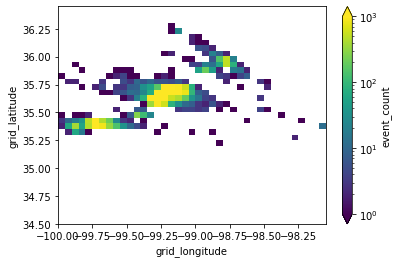

In [39]:
# empty = np.isnan(grid_ds.event_count)
# grid_ds['event_count'] = grid_ds['event_count'].fillna(0)
from matplotlib.colors import LogNorm
grid_ds.event_count.sum(axis=0).plot.imshow(norm=LogNorm(vmin=1, vmax=1000))

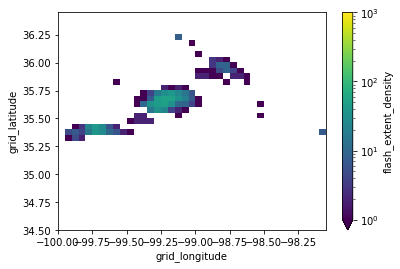

In [40]:
# empty = np.isnan(grid_ds.event_count)
# grid_ds['event_count'] = grid_ds['event_count'].fillna(0)
from matplotlib.colors import LogNorm
grid_ds.flash_extent_density.max(axis=0).plot.imshow(norm=LogNorm(vmin=1, vmax=1000))

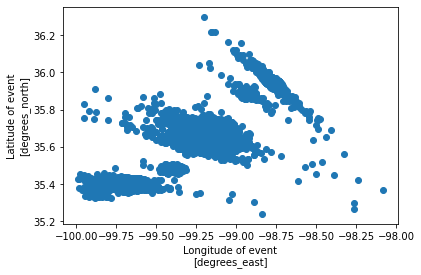

In [15]:
ds.plot.scatter('event_longitude', 'event_latitude')#, c='event_altitude')

In [ ]:
# From glmtools

def get_lutevents(dataset, scale_factor=28e-6, event_dim='number_of_events',
        x_range=(-0.31, 0.31), y_range=(-0.31, 0.31)):
    """ Build an event lookup table. Assign each event location a "sort of"
        pixel ID based on its fixed grid coordinates, discretized to some step
        interval that is less than the minimum pixel spacing of 224 microrad=8
        km at nadir.

        A new location is assigned to each discretized location (mean of the
        locations of  the constituent events). The time is assigned, uniformly,
        to be the dataset's product time attribute.

        The event lookup table is accompanied by pre-accumulated data at each
        discretized location: the flash, group and event counts; total flash and
        group areas; total event energy.

        Returns a new dataset with dimension "lutevent_id", having an index of
        the same name. The dataset is a (shallow) copy, but a new xarray object.

        If needed, returned dataset lutevents can be added to the original
        dataset with dataset.update(lutevents).

        If the pixel ID were stored as a 32 bit unsigned integer,
        (0 to 4294967295) that is 65536 unique values for a square (x,y) grid,
        the minimum safe scale factor for the span of the full disk is
        (0.62e6 microradians)/65536 = 9.46 microradians
        which is a bit large. Therefore, the implementation uses 64 bit unsigned
        integers to be safe.

        Arguments:
        dataset: GLM dataset in xarray format

        Keyword arguments:
        scale_factor: discretization interval, radians (default 28e-6)
        x_range, y_range: range of possible fixed grid coordinate values
            (default -/+.31 radians, which is larger than the
            full disk at geo. Ref: GOES-R PUG Vol. 3, L1b data.)
    """
    # Make a copy of the dataset so we can update it and return a copy.
    # xarray copys are shallow/cheap, and the xarray docs promote returning new
    # datasets http://xarray.pydata.org/en/stable/combining.html
    dataset = dataset.copy()
    event_x, event_y = dataset.event_longtidue.data, dataset.event_latitude.data
    event_energy = dataset.event_power.data
    product_time = dataset.event_time.data
    ev_flash_id = dataset.event_parent_flash_id.data
    flash_area = dataset.flash_area.data

    xy_id = discretize_2d_location(event_x, event_y, scale_factor, x_range, y_range)
    dataset['event_parent_lutevent_id'] = xr.DataArray(xy_id, dims=[event_dim,])
    eventlut_groups = dataset.groupby('event_parent_lutevent_id')
    flash_id_groupby = dataset.groupby('flash_id')
    n_lutevents = len(eventlut_groups.groups)

    # Create a new dimension for the reduced set of events, with their
    # properties aggregated.
    # - Sum: event_energy, flash_area
    # - Mean: event_x, event_y
    # - Count: event_id; unique flash_id
    # - Min: flash_area
    eventlut_dtype = [('lutevent_id', 'u8'),
                      ('lutevent_x', 'f8'),
                      ('lutevent_y', 'f8'),
                      ('lutevent_energy','f8'),
                      ('lutevent_count', 'f4'),
                      ('lutevent_flash_count', 'f4'),
                      ('lutevent_total_flash_area', 'f8'),
                      ('lutevent_time_offset', '<M8[ns]'),
                      ('lutevent_min_flash_area', 'f8')
                      ]

    lut_iter = event_lut_iter(eventlut_groups, flash_id_groupby,
                   event_x, event_y, event_energy, product_time,
                   ev_flash_id, flash_area)
    event_lut = np.fromiter(lut_iter, dtype=eventlut_dtype, count=n_lutevents)
    lutevents = xr.Dataset.from_dataframe(
                    pd.DataFrame(event_lut).set_index('lutevent_id'))
    dataset.update(lutevents)
    return dataset


def event_lut_iter(event_lut_groupby, flash_groupby, 
                   event_x, event_y, event_energy, product_time,
                   ev_flash_id, flash_area):
    flash_groups = flash_groupby.groups
    total_abs_area_delta = 0.0
    total_area = 0.0
    for xy_id, evids in event_lut_groupby.groups.items():
        flash_ids = np.unique(ev_flash_id[evids])
        flash_count = len(flash_ids)
        replicated_flashes = list(itertools.chain.from_iterable(
            flash_groups[fid] for fid in flash_ids))
        total_flash_area = flash_area[replicated_flashes].sum()
        min_flash_area = min((flash_area[flash_groups[fid]].min()
            for fid in flash_ids))
        yield (xy_id,
               event_x[evids].mean(),
               event_y[evids].mean(),
               event_energy[evids].sum(),
               len(evids),
               flash_count,
               total_flash_area,
               product_time,
               min_flash_area
               )
